In [1]:
import logging
logging.basicConfig(level=logging.INFO)
%pylab inline
import mdevaluate as md
import os
%rm -r ./example_data/data

Populating the interactive namespace from numpy and matplotlib


# State of Development: Mdevaluate

Recent changes and new features:

- **`shifted_correlation`: **
  - Keyword `skip=` to skip part of a trajectory at the beginning for analysis
- **Coherent Scattering Function**: Faster N² computations through `numba`
  - `coherent_sum(f, x, y)`: $\sum_{i,j} f(x[i], y[j])$
  - `coherent_hist(f, x, y)`: `histogram`$([f(x[i], y[j]) \quad \forall i,j])$
- **autosave.py**: 
  - Automatic storing & loading of evaluation results
- **Periodic Boundary Conditions**: 
  - Compute the whole or nojump version of a frame (i.e. `gmx trajconv -pbc whole ...`)

## autosave.py

If enabled, the result of calls to `shifted_correlation` and `time_average` will be stored in a file.
When the exact same call is made at a later time, the result will be loaded from this file.

- The filename is deduced from the function call, but nut ALL arguments may be repersented
- Validity of the result is assured by computing a checksum, which depends on all arguments and the function itself
- Two additional optional keywords:
  - `description (str)`: Will be appended to the filename
  - `autoload (bool)`: Controlls if data will be loaded from file


In [2]:
md.autosave.enable('data')
OW = md.open('./example_data').subset(atom_name='OW')
t, msd = md.correlation.shifted_correlation(
    md.correlation.msd,
    OW,
    average=True,
    description='additional_description', # this will be added to the filename
    autoload=True # This keyword may be used to disable autosave locally
)

Enabled autosave in directory: data
Loading topology: ./example_data/topol.tpr
Loading trajectory: ./example_data/traj_full_water1000bulk300.xtc
Saving result to file: ./example_data/data/shifted_correlation_msd_additional_description_OW.npz


## On-the-fly conversion of CoordinateFrames

- Whole: 
  - Atoms are grouped by residue_id and the center of mass of each residue is put into the box
- Nojump: 
  - All pbc-jumps of atoms are corrected for a frame
  - Requires a one-time generation of **nojump matrixes**, 
  - `md.open(..., nojump=True)` generates these matrixes and save them to a file, equiv. to the xtcindex files
  - Reduced Disk Usage: Full nojump.xtc ~ 4GB vs. nojump matrxies ~ 7 MB
  - Uses sparse matrixes internally which are efficient in memory and summation

Loading topology: ./example_data/topol.tpr
Loading trajectory: ./example_data/traj_full_water1000bulk300.xtc


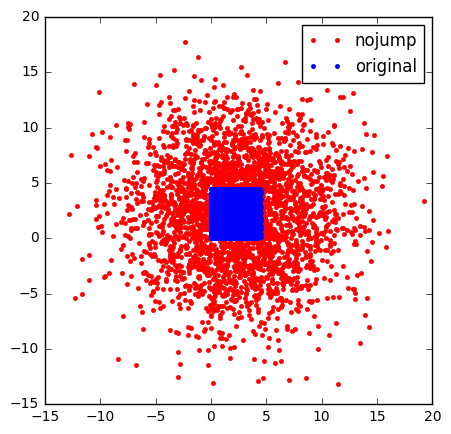

In [3]:
OW = md.open('./example_data/', nojump=True).subset(atom_name='OW')

frame = OW[4000]
figure(figsize=(5, 5))

plot(frame.nojump[:, 0], frame.nojump[:, 1], '.r', label='nojump')
plot(frame[:, 0], frame[:, 1], '.b', label='original')
xlim(-15, 20)
ylim(-15, 20)
legend()

In [17]:
print('No conversion:')
%timeit OW[9000]
print('Whole:')
%timeit OW[9000].whole
print('Nojump:')
%timeit OW[9000].nojump

No conversion:
1000 loops, best of 3: 567 µs per loop
Whole:
1000 loops, best of 3: 1.42 ms per loop
Nojump:
10 loops, best of 3: 67.4 ms per loop


In [7]:
# How to use this in an evaluation:

OW.subset(residue_name='SOL')
# enable nojump mode, other options would be 'pbc' or 'whole'
OW.mode = 'nojump'
t, msd = md.correlation.shifted_correlation(
    md.correlation.msd,
    OW,
    average=True
)

Coordinates <./example_data/traj_full_water1000bulk300.xtc>: Subset of Atoms (3000 of 9000)